In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import gym

import os
import gym
from gym import utils
from gym.envs import mujoco
from gym.envs.robotics import fetch_env
#mujoco.FetchPickAndPlace-v0



tf.keras.backend.set_floatx('float64')

env = gym.make('FetchPickAndPlace-v1')
#env.render()

In [3]:

#https://github.com/openai/gym/blob/master/gym/envs/robotics/fetch/pick_and_place.py

# Ensure we get the path separator correct on windows
MODEL_XML_PATH = os.path.join('fetch', 'pick_and_place.xml')


class FetchPickAndPlaceEnv(fetch_env.FetchEnv, utils.EzPickle):
    def __init__(self, reward_type='sparse'):
        initial_qpos = {
            'robot0:slide0': 0.405,
            'robot0:slide1': 0.48,
            'robot0:slide2': 0.0,
            'object0:joint': [1.25, 0.53, 0.4, 1., 0., 0., 0.],
        }
        fetch_env.FetchEnv.__init__(
            self, MODEL_XML_PATH, has_object=True, block_gripper=False, n_substeps=20,
            gripper_extra_height=0.2, target_in_the_air=True, target_offset=0.0,
            obj_range=0.15, target_range=0.15, distance_threshold=0.05,
            initial_qpos=initial_qpos, reward_type=reward_type)
        utils.EzPickle.__init__(self)

In [4]:
class Actor(tf.keras.Model):
    def __init__(self, hidden_size, output_size):
        super(Actor, self).__init__()
        self.Dense1 = tf.keras.layers.Dense(hidden_size, activation='relu')
        self.Dense2 = tf.keras.layers.Dense(hidden_size, activation='relu')
        self.out = tf.keras.layers.Dense(output_size, activation='tanh')
        
    def call(self, state):
        x = self.Dense1(state)
        x = self.Dense2(x)
        return self.out(x)
    
class Critic(tf.keras.Model):
    def __init__(self, hidden_size, output_size):
        super(Critic, self).__init__()
        self.Dense1 = tf.keras.layers.Dense(hidden_size, activation='relu')
        self.Dense2 = tf.keras.layers.Dense(hidden_size, activation='relu')
        self.out = tf.keras.layers.Dense(output_size)
        
    def call(self, state, actions):
        x = tf.concat([state, actions], 1)
        x = self.Dense1(x)
        x = self.Dense2(x)
        return self.out(x)

In [5]:
from collections import deque
import random

class ReplayMemory:
    def __init__(self, size):
        self.buffer = deque(maxlen=size)
        
    def push(self, state, action, reward, next_state, done, goal):
        new_experience = (state, action, [reward], next_state, done, goal)
        self.buffer.append(new_experience)
        
    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []
        goal_batch = []
        
        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done, goal = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)
            goal_batch.append(goal)
        
        return (np.array(state_batch), np.array(action_batch), 
                np.array(reward_batch), np.array(next_state_batch), 
                np.array(done_batch),np.array(goal_batch))
 
        
    def __len__(self):
        return len(self.buffer)
    
# Ornstein-Ulhenbeck Process
# Taken from #https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)
    
# https://github.com/openai/gym/blob/master/gym/core.py
class NormalizedEnv(gym.ActionWrapper):
    """ Wrap action """

    def action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b

    def reverse_action(self, action):
        act_k_inv = 2./(self.action_space.high - self.action_space.low)
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k_inv * (action - act_b)

In [ ]:
"""
import pybullet_envs
import gym
from gym import utils
from gym.envs.robotics import fetch_env
gym.logger.set_level(40)
"""
#env = NormalizedEnv(gym.make('HalfCheetahBulletEnv-v0'))
#env = NormalizedEnv(gym.make('FetchPickAndPlace-v0'))
env = gym.make('FetchPickAndPlace-v1')
HER_active=False

env.render()
num_ep = 200
batch_size = 128
memory_size = 50000
tau = 1e-2
gamma = 0.99

# Initialize Actor and Critic Networks and Target Networks and Optimizers
actor = Actor(400, 6)
critic = Critic(400, 6)

actor_target = Actor(400, 6)
critic_target = Critic(400, 6)

actor_target.set_weights(actor.get_weights())
critic_target.set_weights(critic.get_weights())

critic_optimizer = tf.keras.optimizers.Adam(lr=0.001)
actor_optimizer = tf.keras.optimizers.Adam(lr=0.0001)

# Initialize Replay Memory
memory = ReplayMemory(memory_size)
# Initialize HER Replay Memory
HER_memory = ReplayMemory(memory_size)

# Initialize Noise
noise = OUNoise(env.action_space)

reward_hist = []

for ep in range(num_ep):
    # Initialize Random Process
    noise.reset()
    
    # Get Initial Observation
    observation = env.reset()
    
    # Reset Stats
    total_reward = 0
    reward_max = 0
    stale = 0
    
    for t in range(10000):
        # Select action from policy and noise
        action = actor(np.array([observation,]))[0]
        action = noise.get_action(action, t)
        
        # Execute action and observe reward/new state
        new_observation, reward, done, info = env.step(action)
        #Scott: goal is not returned with env.step. 
        
        # Store transition is replay memory
        memory.push(observation, action, reward, new_observation, done, goal)
        
        
            
        
        # Sample minibatch and perform update
        if len(memory) > batch_size:
        
            if HER_active==True:
            #inspired by https://github.com/buntyke/her/blob/master/ddpg_her.py    
            
                # get K future states per time step
                for t in range(len(memory)):
                    for n in range(K): # K = args ratio WE NEED TO SET K!
                    # get random future t
                        future = np.random.randint(t, len(memory))

                        # get new goal at t_future
                        #Scott: NEED TO FIX memory location references!!!
                        HER_state = memory[t][0]
                        HER_action = memory[t][1]
                        HER_next_state = memory[t][3]
                        HER_goal = memory[future][3] 
                        HER_done, HER_reward = env.reward_func(HER_next_state, HER_goal)

                        # add new experience to her
                        HER_memory.add(HER_state, HER_action, HER_reward, 
                                                          HER_next_state, HER_done, HER_goal)
               
                (state_batch, action_batch, reward_batch, next_state_batch, 
                 done_batch, goal_batch) = HER_memory.sample(batch_size) 
                
                #clear HER memory
                HER_memory = ReplayMemory(memory_size)
            
            (state_batch, action_batch, reward_batch, next_state_batch, 
             done_batch, goal_batch) = memory.sample(batch_size)
            
            # Update Critic
            with tf.GradientTape() as tape:
                next_act = actor_target(next_state_batch)
                next_q = critic_target(next_state_batch, next_act)
                y = reward_batch + gamma * next_q
                cur_q = critic(state_batch, action_batch)
                loss = tf.reduce_mean((y-cur_q)**2)
            grad = tape.gradient(loss, critic.trainable_variables)
            critic_optimizer.apply_gradients(zip(grad, critic.trainable_variables))
            
            # Update Actor
            with tf.GradientTape() as tape:
                new_q = critic(state_batch, actor(state_batch))
                loss = -1 * tf.reduce_mean(new_q)
            grad = tape.gradient(loss, actor.trainable_variables)
            actor_optimizer.apply_gradients(zip(grad, actor.trainable_variables))
            
            # Update target networks
            actor_target.set_weights(tau * np.array(actor.get_weights()) + (1 - tau) * np.array(
                actor_target.get_weights()))
            critic_target.set_weights(tau * np.array(critic.get_weights()) + (1 - tau) * np.array(
                critic_target.get_weights()))
            
        
        total_reward += reward
        if done:
            #print("stepcounter= ",t)
            break
        #if total_reward > reward_max:
        #    reward_max = total_reward
        #else:
        #    stale += 1
        #if stale > 500:
        #    break
        observation = new_observation
        
    print("Episode {} completed: {}".format(ep+1, total_reward))
    reward_hist.append(total_reward)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./assets


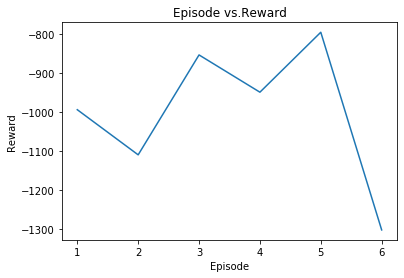

In [15]:
actor.save('./')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Episode')
ax.set_ylabel('Reward')
ax.set_title('Episode vs.Reward')

ax.plot(list(range(1, len(reward_hist)+1)), reward_hist)

In [16]:
import pybullet_envs
import pybullet as p
import time
from gym.wrappers import Monitor
gym.logger.set_level(40)

actor = tf.keras.models.load_model('./')

env = NormalizedEnv(gym.make('HalfCheetahBulletEnv-v0'))
env.spec.timestep_limit = 9000


observation = env.reset()
reward_hist = []

for ep in range(200):
    total_reward = 0
    observation = env.reset()
    for t in range(10000):
        # Select action from policy and noise
        action = actor(np.array([observation,]))[0]

        # Execute action and observe reward/new state
        new_observation, reward, done, info = env.step(action)
        total_reward += reward
        if done:
            break
        observation = new_observation
    reward_hist.append(total_reward)
env.close()

KeyboardInterrupt: 

In [2]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.set_xlabel('Episode')
ax.set_ylabel('Reward')
ax.set_title('Episode vs.Reward')

ax.plot(list(range(1, len(reward_hist)+1)), reward_hist)

NameError: name 'plt' is not defined

In [ ]:
import pybullet_envs
import pybullet as p
import time
from gym.wrappers import Monitor
gym.logger.set_level(40)

actor = tf.keras.models.load_model('./')

env = NormalizedEnv(gym.make('HalfCheetahBulletEnv-v0'))
env.spec.timestep_limit = 9000

env = Monitor(env, "recordings", video_callable=lambda episode_id: True, force="true")

env.render(mode="human")
observation = env.reset()


total_reward = 0
for t in range(10000):
    # Select action from policy and noise
    action = actor(np.array([observation,]))[0]

    # Execute action and observe reward/new state
    new_observation, reward, done, info = env.step(tf.make_ndarray(action))
    env.render(mode="human")
    total_reward += reward
    if done:
        print("here")
        break
    observation = new_observation
print('Total reward: {}'.format(total_reward))
env.close()

In [3]:
import gym
import pybullet_envs
env = gym.make('HalfCheetahBulletEnv-v0')
print(env.action_space.high)
print(env.action_space.low)
print(env.observation_space.high)
print(env.observation_space.low)

[1. 1. 1. 1. 1. 1.]
[-1. -1. -1. -1. -1. -1.]
[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
